** Libraries import **

In [24]:
!pip install SimpleITK-SimpleElastix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import cv2
from skimage import exposure
import numpy as np
import numpy as np                                            
import matplotlib.pyplot as plt                 
from sklearn.cluster import KMeans
from skimage import measure, morphology, segmentation 
import SimpleITK as sitk
import nibabel as nib
import scipy.ndimage
from scipy import ndimage as ndi
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing, opening
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
import skimage.morphology
from skimage.morphology import closing, square,cube, dilation, ball
from skimage import measure, feature
from skimage.segmentation import clear_border, mark_boundaries
import os
from google.colab import drive
import math
from sklearn.preprocessing import MinMaxScaler

In [26]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
#Working directories
input_directory= '/content/gdrive/MyDrive/Colab Notebooks/Final Project MIRA/'
train_directory = input_directory+'train' 
test_directory = input_directory+'test'
parameters_directory= input_directory+'parameters'


In [28]:
def slice_show(image, slice_no, title,nibabel):
    """
    Function to visualize a 2D slice from the 3D image. 

    Args: 
    image (nifti, sitk.Image): Image that needs to be visualized.
    slice_no (int): Slice Number from 1 to 48.
    title (str): Title of the Image.
    nibabel => Boolean variable to know whether the image was loaded with nibabel or simpleITK library.
    
    Returns:
    (plt) Plot Image.

    """ 
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.title(title)
    if nibabel==True:
        plt.imshow(image[:,:,slice_no].T, cmap='gray') # Transpose the slice image from the one read by Nibabel as we want to see vertical image
    else:
        plt.imshow(image[:,:,slice_no], cmap='gray') # Transpose the slice image from the one read by Nibabel as we want to see vertical image
    #plt.imshow(image[:,:,slice_no].T, cmap='gray') # Transpose the slice image from the one read by Nibabel as we want to see vertical image

In [29]:
def computeTRE(transformed, target, voxel_size):
  """
  Function to compute the TRE between the transformed and target landmarks. 
  
  Args: 
  transformed (list): contains the transformed landmarks coordinates in x,y and z dimension.
  target (list): contains the landmarks coordinates of target image in x,y and z dimension.
  voxel_size (list): voxel spacing in x,y and z dimension.
  
  Returns: 
  tre_error (float) returns the TRE error per each pair of the landmark point.

  """ 

  #Computation of the TRE for each image coordinate
  x_diff_sqr =  pow(((transformed[0] - target[0])*voxel_size[0]),2)
  y_diff_sqr =  pow(((transformed[1] - target[1])*voxel_size[1]),2)
  z_diff_sqr =  pow(((transformed[2] - target[2])*voxel_size[2]),2)

  tre_error = math.sqrt(x_diff_sqr + y_diff_sqr + z_diff_sqr) # 3D Eucledian Distance Computation

  return tre_error

In [30]:
def computeTRE_MeanStd(transformed_landmarks, target_landmarks, voxel_size):
  """
  Function to compute the mean of the TRE and Standard deviation for 
  
  Inputs: 
  transformed_landmarks (list): a list of the transformed landmark points.
  target_landmarks (list): a list of the target image landmark points.
  voxel_size (list): voxel spacing in x,y and z dimension.
  
  output: returns the mean and std of TRE error per pair of the given two images.

  """ 
  all_tre = [] # A list which will hold all the TRE per point

  #Computation of the mean and standard deviation of the TRE 
  for i in range(len(transformed_landmarks)):
    temp_tre = computeTRE(transformed_landmarks[i], target_landmarks[i], voxel_size)
    all_tre.append(temp_tre)
  mean_tre = np.mean(all_tre) # Mean
  std_tre = np.std(all_tre) # Standard deviation
  return mean_tre, std_tre

In [31]:
def loadData(directory):
  """
  Function to load the data from a given directory in order to get it ready to work.

  Args:
  directory  (str): he place where train/validation/test images and landmarks are stored,

  Returns:
  inhale_images (list): list of the inhale images of all the patient.
  exhale_images (list): list of the exhale images of all the patient.
  inhale_images_metadata (sitk.Image): SimpleITK object of the inhale image. 
  exhale_images_metadata (sitk.Image): SimpleITK object of the exhale image.
  inhale_landmarks (list): list of the inhale image landmarks of all the patients.
  exhale_landmarks (list): list of the exhale image landmarks of all the patients.
  voxel_size_list (list): list of the voxel dimensions of the images of all the patient.

  """
  inhale_images = []
  exhale_images = []
  inhale_images_metadata = []
  exhale_images_metadata = []
  inhale_landmarks = []
  exhale_landmarks = []
  voxel_size_list = []


  for folders in sorted(os.listdir(directory)):
    images_directory = os.path.join(directory, folders) # Accessing each patient folder
    for files in sorted(os.listdir(images_directory)):
      if '.txt' in files: # Accessing each landmark files
        if '_eBH' in files: # Accessing each exhale landmark files
          with open(os.path.join(images_directory, files)) as f:
            exhale_landmarks_raw = []
            for line in f:
              exhale_landmarks_raw.append([float(n) for n in line.strip().split('\t')]) # Converting the text file to a list of points
            exhale_landmarks.append(exhale_landmarks_raw)
        elif '_iBH' in files: # Accessing each inhale landmark files
          with open(os.path.join(images_directory, files)) as f:
            inhale_landmarks_raw = []
            for line in f.readlines()[2:]:
              inhale_landmarks_raw.append([float(n) for n in line.strip().split('\t')]) # Converting the text file to a list of points
            inhale_landmarks.append(inhale_landmarks_raw)
        else:
          pass 
      else:
        if '_eBH' in files: # Accessing each exhale image files
          exhale_img_data= sitk.ReadImage(os.path.join(images_directory,files))
          exhale_images_metadata.append(exhale_img_data)
          sx,sy,sz= exhale_img_data.GetSpacing()
          voxel_size = [sx, sy, sz]
          voxel_size_list.append(voxel_size)
          exhale_img = np.moveaxis(sitk.GetArrayFromImage(exhale_img_data),0,-1)
          exhale_images.append(exhale_img)
        elif '_iBH' in files: # Accessing each inhale image files
          inhale_img_data = sitk.ReadImage(os.path.join(images_directory, files)) # reading the .nii image
          inhale_images_metadata.append(inhale_img_data)
          inhale_img = np.moveaxis(sitk.GetArrayFromImage(inhale_img_data),0,-1) 
          inhale_images.append(inhale_img)
        else: 
          pass
  return inhale_images, exhale_images, inhale_images_metadata, exhale_images_metadata, inhale_landmarks,exhale_landmarks, voxel_size_list

In [32]:
def preprocessImages(inhale_images, exhale_images,inhale_images_metadata, exhale_images_metadata):
    """
        Function to preprocess the raw images. 

        Args: 
        inhale_images (np.ndarray): 3D numpy array corresponding to the inhale image
        exhale_images (np.ndarray): 3D numpy array corresponding to the exhale image
        inhale_images_metadata (sitk.Image): SimpleITK image object corresponding to the inhale image
        exhale_images_metadata (sitk.Image): SimpleITK image object corresponding to the exhale image

        Returns: 
        preprocess_inhale (np.ndarray): 3D numpy array corresponding to the inhale image after preprocessing
        preprocess_exhale (np.ndarray): 3D numpy array corresponding to the exhale image after preprocessing
        preprocess_inhale_metadata (sitk.Image): SimpleITK image object corresponding to the inhale image after preprocessing
        preprocess_exhale_metadata (sitk.Image): SimpleITK image object corresponding to the exhale image after preprocessing

    """
    preprocess_inhale=[]
    preprocess_exhale=[]
    preprocess_inhale_metadata=[]
    preprocessed_exhale_metadata=[]

    for i in range(len(inhale_images)):
        preprocess_directory= train_directory+'/'+str(i+1)+"/"

        #Copy of input images
        inhale_images_array= inhale_images[i].copy()
        exhale_images_array= exhale_images[i].copy()

        #Setting to 0 pizels with value -2000
        inhale_images_array[inhale_images_array<0]=0
        exhale_images_array[exhale_images_array<0]=0
        
        #Obtaining min and max of both inhale and exhale images
        min_inhale= inhale_images_array.min()
        max_inhale= inhale_images_array.max()
        min_exhale= exhale_images_array.min()
        max_exhale= exhale_images_array.max()
        
        #Min-max normalization of both inhale and exhale images
        inhale_normalized= (inhale_images_array-min_inhale)/(max_inhale-min_inhale)
        exhale_normalized= (exhale_images_array-min_exhale)/(max_exhale-min_exhale)
        inhale_normalized *= 65535
        exhale_normalized *= 65535

        #Converting 3D numpy array to SimpleITK image object 
        inhale_preprocess_img = sitk.GetImageFromArray(np.moveaxis(inhale_normalized,-1,0))
        inhale_preprocess_img.CopyInformation(inhale_images_metadata[i])

        exhale_preprocess_img = sitk.GetImageFromArray(np.moveaxis(exhale_normalized,-1,0))
        exhale_preprocess_img.CopyInformation(exhale_images_metadata[i]) 

        #Exporting the image
        sitk.WriteImage(inhale_preprocess_img, preprocess_directory+"inhale_preprocessed"+str(i+1)+".nii.gz")
        sitk.WriteImage(exhale_preprocess_img, preprocess_directory+"exhale_preprocessed"+str(i+1)+".nii.gz")
        
        #Saving the results in the corresponding lists
        preprocess_inhale.append(inhale_normalized)
        preprocess_exhale.append(exhale_normalized)
        preprocess_inhale_metadata.append(inhale_preprocess_img)
        preprocessed_exhale_metadata.append(exhale_preprocess_img)

    return preprocess_inhale, preprocess_exhale, preprocess_inhale_metadata, preprocessed_exhale_metadata
    

In [33]:
def ConvertToHU(source_img):
    """
        Function to convert image to HU units.
        
        Args: 
        source_img (sitk.Image): source image in SimpleITK format. 

        Returns: 
        hu_img_array (np.ndarray): 3D numpy array with the image converted to HU units. 

    """
    
    #Rescaling the intensity of the image
    hu_img= sitk.RescaleIntensity(source_img,-1000,1000)
    hu_img_array= np.moveaxis(sitk.GetArrayFromImage(hu_img),0,-1)

    return hu_img_array

In [34]:
test_inhale_images,test_exhale_images,test_inhale_images_metadata,test_exhale_images_metadata,test_inhale_landmarks,test_exhale_landmarks, patient_voxel_size_list = loadData(test_directory)

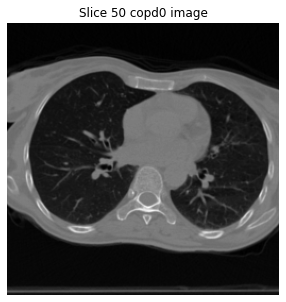

In [44]:
slice_show(test_inhale_images[0],50,'Slice 50 copd0 image',False)

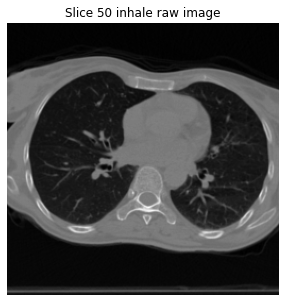

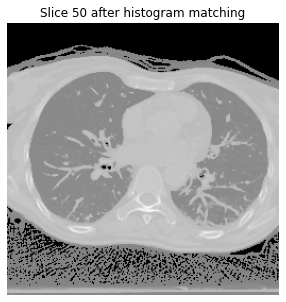

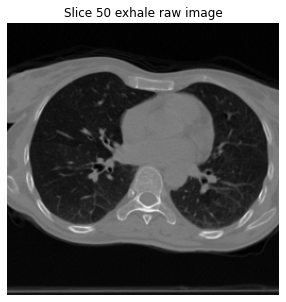

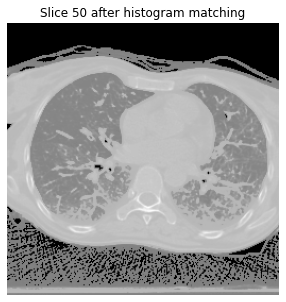

In [43]:
matched_inhale_0 = exposure.match_histograms(test_inhale_images[0], test_inhale_images[1], multichannel=False)
matched_exhale_0 = exposure.match_histograms(test_exhale_images[0], test_exhale_images[1], multichannel=False)
slice_show(test_inhale_images[0],50,'Slice 50 inhale raw image',False)
slice_show(matched_inhale_0,50,'Slice 50 after histogram matching',False)

slice_show(test_exhale_images[0],50,'Slice 50 exhale raw image',False)
slice_show(matched_exhale_0,50,'Slice 50 after histogram matching',False)

In [ ]:
test_inhale_images[0] = matched_inhale_0
test_exhale_images[0] = matched_exhale_0

In [12]:
# Preprocessed images
preprocessed_inhale, preprocessed_exhale, preprocessed_inhale_metadata, preprocessed_exhale_metadata = preprocessImages(test_inhale_images, test_exhale_images,test_inhale_images_metadata, test_exhale_images_metadata)

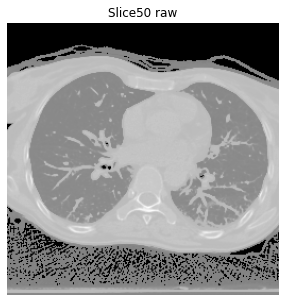

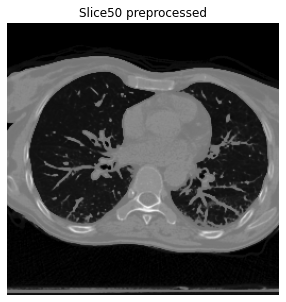

In [ ]:
# Examples of image before and after preprocessing
slice_show(test_inhale_images[0],50,'Slice50 raw',False)
slice_show(preprocessed_inhale[0],50,'Slice50 preprocessed',False)

In [13]:
#Converting inhale images to HU units
HU_images_sitk_inhale=[]
for i in range(3):
    HU_images_sitk_inhale.append(ConvertToHU(preprocessed_inhale_metadata[i]))

In [14]:
#Converting exhale images to HU units
HU_images_sitk_exhale=[]
for i in range(3):
    HU_images_sitk_exhale.append(ConvertToHU(preprocessed_exhale_metadata[i]))

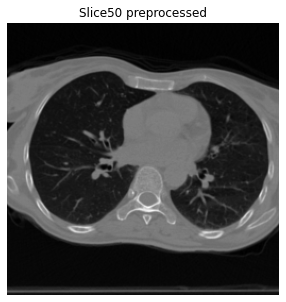

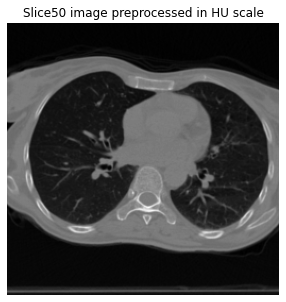

In [15]:
#Comparison of image after preprocessing 
slice_show(preprocessed_inhale[0],50,'Slice50 preprocessed',False)
slice_show(HU_images_sitk_inhale[0],50,'Slice50 image preprocessed in HU scale',False)

## Initial results: TRE between fixed and moving image

In [16]:
def output_landmarks(patient_directory):
  """
        Function to get the output landmarks from the specified file.
        
        Args: 
        patient_directory (str): directory of the output landmarks .txt file.

        Returns: 
        output_points (list): list containing the output landmarks. 

   """
  output_points=[]
  for files in sorted(os.listdir(patient_directory)):
    #Searching for the output points .txt file
    if 'outputpoints.txt' in files: 
      with open(os.path.join(patient_directory, files)) as f:
        lines_list= f.readlines()
        str_lines= [line.split(';') for line in lines_list]
        #Finding the column corresponding to the output index and converting it to list
        for i in range(len(str_lines)):
          start_index_output= str_lines[i][3].find('[')
          end_index_output= str_lines[i][3].find(']')
          out_pnts= str_lines[i][3][start_index_output+1:end_index_output].split()
          out_pnts_int= [int(x) for x in out_pnts]
          output_points.append(out_pnts_int)
  return output_points

In [17]:
def ImageRegistrationFramework(test_inhale_images_metadata, test_exhale_images_metadata,is_file,is_several,train,mask,masks_inhale, masks_exhale,parameter_map,experiment_number):

  """
        Function to perform image registration.
        
        Args: 
        train_inhale_images_metadata (sitk.Image): SimpleITK image corresponding to the inhale image.
        train_exhale_images_metadata (sitk.Image): SimpleITK image corresponding to the exhale image.
        is_file (bool): boolean variable used as flag. If true, registration parameter is a file. If false, default parameters are used.
        is_several (bool): boolean variable used as flag. If true, registration parameters is a group of parameters. If false, only one parameter is used.
        train (bool): boolean variable used as flag. If true, computation of TRE is done. 
        mask (bool): boolean variable used as flag. If true, masks are used for the registration. If false, masks are not used for the registration.
        mask_inhale (list): segmentation mask for the inhale image.
        mask_exhale (list): segmentation mask for the exhale image.
        parameter_map (str, list): registration parameter map. Str if only one parameter is used, list of strings if several parameters are used. 
        experiment_number (int): number of the experiment being done. 
        Returns: 
        TRE_population (list): list with the mean TRE and std of the TRE for each of the patients. 
        transformed_landmarks_population (list): list with the transformed landmarks after doing the transformation with the transformation parameters from the registration. 

  """


  TRE_population=[]
  transformed_landmarks_population=[]

  for i in range(len(test_inhale_images_metadata)):
    #Getting the fixed and moving image
    current_fixed_img= test_inhale_images_metadata[i]
    current_moving_img= test_exhale_images_metadata[i]
    if i==0:
      current_output_directory= test_directory+'/0'+'/Experiment_'+str(experiment_number)
    elif i==1:
      current_output_directory= test_directory+'/5'+'/Experiment_'+str(experiment_number)
    elif i==2:
      current_output_directory= test_directory+'/6'+'/Experiment_'+str(experiment_number)
    else: 
      pass 
    #Creating the folder corresponding to the experiment being done 
    os.mkdir(current_output_directory)
    output_registered_image= current_output_directory+'/registered_image'+str(i+1)+'.nii.gz'
    elastixImageFilter = sitk.ElastixImageFilter()
    if mask== True:
      #Setting fixed and moving image, fixed and moving mask
      elastixImageFilter.SetFixedImage(current_fixed_img)
      elastixImageFilter.SetMovingImage(current_moving_img)
      mask_i= sitk.Cast(sitk.GetImageFromArray(np.moveaxis(masks_inhale[i],-1,0)), sitk.sitkUInt8)
      mask_e= sitk.Cast(sitk.GetImageFromArray(np.moveaxis(masks_exhale[i],-1,0)),sitk.sitkUInt8)
      mask_i.CopyInformation(current_fixed_img)
      mask_e.CopyInformation(current_moving_img)
      
      elastixImageFilter.SetFixedMask(mask_i)
      elastixImageFilter.SetMovingMask(mask_e)
    else: 
      #Setting fixed and moving image
      elastixImageFilter.SetFixedImage(current_fixed_img)
      elastixImageFilter.SetMovingImage(current_moving_img)

    if is_file== True:
      if is_several == True and parameter_map != None: 
        #Creation of parameter vector map
        parameterMapVector = sitk.VectorOfParameterMap()
        for p in parameter_map:
          parameterMapVector.append(sitk.ReadParameterFile(p))
        #Setting parameter map
        elastixImageFilter.SetParameterMap(parameterMapVector)
      elif is_several == False:
        #Setting parameter map
        elastixImageFilter.SetParameterMap(sitk.ReadParameterFile(parameter_map))
      else: 
        pass 
    elif is_file==False:
      if is_several == True and parameter_map != None:
        #Creation of default parameter vector map
        parameterMapVector = sitk.VectorOfParameterMap()
        for p in parameter_map:
          parameterMapVector.append(sitk.GetDefaultParameterMap(p))
        #Setting parameter map
        elastixImageFilter.SetParameterMap(parameterMapVector)
      elif is_several == False: 
        #Setting default parameter map
        elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap(parameter_map))
      else: 
        pass 
    else: 
      pass
    #Image registration
    elastixImageFilter.Execute()
    transformed_parameter_map= elastixImageFilter.GetTransformParameterMap()
    #Registered image is exported 
    sitk.WriteImage(elastixImageFilter.GetResultImage(),output_registered_image)
    # Transformation of landmarks with the deformation map obtained in the registration
    transformixImageFilter = sitk.TransformixImageFilter()

    # Set Moving image
    transformixImageFilter.SetMovingImage(current_moving_img)

    # Set the transformation parameter map
    transformixImageFilter.SetTransformParameterMap(transformed_parameter_map)

    # Set Points to be transformed 
    if i==0:
      transformixImageFilter.SetFixedPointSetFileName(test_directory+'/0'+'/copd0'+'_300_iBH_xyz_r1.txt')
    elif i==1:
      transformixImageFilter.SetFixedPointSetFileName(test_directory+'/5'+'/copd5'+'_300_iBH_xyz_r1.txt')
    elif i==2:
      transformixImageFilter.SetFixedPointSetFileName(test_directory+'/6'+'/copd6'+'_300_iBH_xyz_r1.txt')
    else:
      pass
    transformixImageFilter.SetOutputDirectory(current_output_directory)
    transformixImageFilter.Execute()


    #Getting the transformed landmarks
    transformed_landmarks= output_landmarks(current_output_directory)
    transformed_landmarks_population.append(transformed_landmarks)
    
    #Calculating the TRE for the current experiment
    if train == True:
      patient_mean_tre, patient_std_tre = computeTRE_MeanStd(transformed_landmarks, test_exhale_landmarks[i], patient_voxel_size_list[i])
      print("For experiment {}, Patient #{}, the mean TRE is: {}, and the Std of the TRE is: {}".format(experiment_number,i+1,patient_mean_tre, patient_std_tre))
      TRE_patient= [patient_mean_tre, patient_std_tre]
      TRE_population.append(TRE_patient)
    else:
      pass 
    
  return TRE_population, transformed_landmarks_population

## Experiments

## Segmentation of the lungs

In [18]:
def LungMarkers(input_image):

    """
        Function to generate useful lung markers for segmentation of the lungs 

        Inputs:
        input_image (np.ndarray): 3D numpy array corresponding to the input image from which to perform lung segmentation. 
        
        Returns:
        inner_lung_marker (np.ndarray): 3D numpy array containing the binary image that corresponds to the inner lung marker
        out_lung_marker (np.ndarray): 3D numpy array containing the binary image that corresponds to the external lung marker
        ws_marker (np.ndarray): 3D numpy array corresponding to the combination of inner and external lung markers to be used in
        the watershed algorithm. 

    """
    #Initial threshold of the image according to typical range of HU values for the lungs (-600)
    threshold_image= input_image< -600
    #Clearing borders (bone not corresponding to the lungs area)
    for slices in range(threshold_image.shape[2]):
        threshold_image[:,:,slices] = threshold_image[:,:,slices]
        threshold_image[:,:,slices] = clear_border(threshold_image[:,:,slices])
    #Getting image properties and ordering them by area
    lung_labels= measure.label(threshold_image)
    lung_regions_props = measure.regionprops(lung_labels)
    lung_regions_props.sort(key = lambda region: region.area)
    #Keeping largest area regions (corresponding to the lung)
    for region in lung_regions_props[:-1]:
        coordinates = tuple([tuple(k) for k in region.coords.transpose()])
        lung_labels[coordinates] = 0
    
    # Inner marker
    inner_lung_marker = lung_labels > 0
    
    #Generation of external markers 
    out_marker_in_layer= scipy.ndimage.binary_dilation(inner_lung_marker, iterations = 10)
    out_marker_out_layer= scipy.ndimage.binary_dilation(inner_lung_marker, iterations = 40 )
    out_lung_marker = out_marker_in_layer ^ out_marker_out_layer
    
    # Final marker for watershed algorithm 
    ws_marker = inner_lung_marker.astype(np.int16) * 2 + out_lung_marker.astype(np.int16) * 1
    
    
    return inner_lung_marker, out_lung_marker, ws_marker


In [19]:
def LungSegmentation(img_slice,inner_lung_marker, ws_marker):
  """
        Function to generate the segmentation of the lungs

        Inputs:
        inner_lung_marker (np.ndarray): 3D numpy array corresponding to the inner lung marker
        ws_marker (np.ndarray): 3D numpy array corresponding to the watershed marker
        input_img (np.ndarray): 3D numpy array corresponding to the input image

        Returns:
        lung_borders(np.ndarray): 3D numpy array containing the borders detected in the image
        lung_segmentation (np.ndarray): 3D numpy array containing the final segmentation of the lung
        ws_lung (np.ndarray): 3D numpy array of the binary mask generated for the lung after applying watershed algorithm
        the watershed algorithm. 
        edges (np.ndarray): 3D numpy array corresponding to the edges detected in the image.
    """

    #Edges detection with sobel filter
  Ix= scipy.ndimage.sobel(img_slice, axis=0)
  Iy= scipy.ndimage.sobel(img_slice, axis=1)
  edges= np.hypot(Ix,Iy)
    
    # Watershed algorithm from the markers
  ws_lung = skimage.segmentation.watershed(edges, ws_marker)
    
    # Watershed result
  lung_borders = scipy.ndimage.morphological_gradient(ws_lung, size=(3,3)).astype(bool)
    
    # combine the lung and the regions near its border which may contain nodules
  lung_segmentation = np.bitwise_or(inner_lung_marker, lung_borders)
    # remove the small air pockets inside the lung
  lung_segmentation = scipy.ndimage.binary_fill_holes(lung_segmentation)
    
  return lung_borders, lung_segmentation, ws_lung,edges


In [51]:
#Creation of the inhale and exhale lung image masks 
masks_inhale=np.zeros(HU_images_sitk_inhale[0].shape)
masks_exhale=np.zeros(HU_images_sitk_exhale[0].shape)
for i in range(len(HU_images_sitk_inhale)):
    inner_lung_marker, out_lung_marker, ws_marker = LungMarkers(HU_images_sitk_inhale[i])
    inner_lung_marker2, out_lung_marker2, ws_marker2 = LungMarkers(HU_images_sitk_exhale[i])
    for k in range(HU_images_sitk_inhale[i].shape[2]):
      _,lung_segmentation_inhale,_,_= LungSegmentation(k,inner_lung_marker, ws_marker)
      _,lung_segmentation_exhale,_,_= LungSegmentation(k, inner_lung_marker2, ws_marker2)
      masks_inhale[k] = lung_segmentation_inhale 
      masks_exhale[k] = lung_segmentation_exhale 

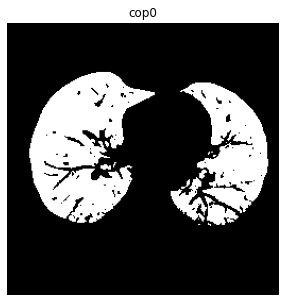

In [ ]:
slice_show(masks_inhale[0],50,'cop0',False)

In [ ]:
def output_transformed_landmarks(transformed_marks_directory, output_landmarks_vector):
  """
        Function to output a .txt file with the transformed lanmarks points indexes 

        Inputs:
        transformed_marks_directory (str): directory where the file will be saved
        output_landmarks_vector (list): list with the landmarks indexes 

        After the function is executed, the .txt file with the transformed lanmarks is generated.    
  """
  #Writing the .txt file with all the vectors of output points separating the points with a space. 
  with open(transformed_marks_directory, 'w') as f:
    for points in output_landmarks_vector:
      f.write(' '.join(map(str,points))+'\n')
    

# Generation of results

In [ ]:
fexperiment_1, output_landmarks_1= ImageRegistrationFramework(preprocessed_inhale_metadata, preprocessed_exhale_metadata,True,True,False,True,masks_inhale,masks_exhale,[parameters_directory+"/015/Parameters.Par0015.expA.patient.NC.affine.txt",parameters_directory+"/035/Par0035.SPREAD.MI.af.0.txt",parameters_directory+"/015/Parameters.Par0015.expA.patient.NC.bspline.txt",parameters_directory+"/015/Parameters.Par0015.expA.patient.LNC.bspline.txt",parameters_directory+"/035/Par0035.SPREAD.MI.bs.1.ASGDPrime.txt",],1)